<a href="https://colab.research.google.com/github/simonZhou86/Sentiment-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CISC 372 Assignnment 4 - Sentiment Analysis

Author: Simon Zhou

## Loading Packages:

In [ ]:
# loading the required packages
import copy
import pandas as pd
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from __future__ import absolute_import, division, print_function, unicode_literals
from keras.utils import to_categorical
import collections
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import  f1_score
from sklearn.metrics import confusion_matrix
from gensim.models import KeyedVectors
%matplotlib inline
print("finish loading")

finish loading


In [ ]:
import nltk # downloading required packages from nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
!wget -q https://github.com/CISC-372/Notebook/releases/download/a4/test.csv
!wget -q https://github.com/CISC-372/Notebook/releases/download/a4/train.csv

## Text Understanding and Preprocessing:

In [ ]:
# comment your understanding of each function 


xy_train_df = pd.read_csv('train.csv')
x_test_df  = pd.read_csv('test.csv', index_col='id') # remove the additional index column


xy_train_df['length'] = xy_train_df.apply(lambda x: len(x.review), axis=1) # calculate each review length
xy_train_df = xy_train_df.sort_values('length') # sort by length, in accsending order
xy_train_df # display training dataset

,id,rating,review,length
6037,2596,1,Five Stars_GOOD,15
5353,4643,1,Love it_Love it,15
2545,8791,1,Five Stars_Good,15
3902,6098,1,Five Stars_love!,16
2850,4609,1,love these_so cute!,19
...,...,...,...,...
5651,518,1,"So far, it's awesome_Ok, so I'll say up front ...",5765
1615,124,1,It Works (Read Tips For Potential Effectivenes...,6740
5046,7257,1,An exquisitely effective product with an astou...,8082
4859,7555,1,Gorgeous professional looking manicure at home...,8134


In [ ]:
xy_train_df[xy_train_df["id"] == 4823]

,id,rating,review,length
2758,4823,1,WAITED TO WRITE THIS REVIEW UNTIL AFTER READIN...,12773


In [ ]:
xy_train_df.info() # get the basic information of the dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6223 entries, 6037 to 2758
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6223 non-null   int64 
 1   rating  6223 non-null   int64 
 2   review  6223 non-null   object
 3   length  6223 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 243.1+ KB


In [ ]:
x_test_df['length'] = x_test_df.apply(lambda x: len(x.review), axis=1)
x_test_df = x_test_df.sort_values('length')
x_test_df # display the test dataset

,review,length
id,,
8950,Five Stars_Love them,20
4945,Five Stars_Nice color,21
9936,NICE_NICE PRODUCT LIKE AAA,26
4855,Five Stars_I like this color!,29
6853,"One Star_boo. cheap, don't buy.",31
...,...,...
8122,"Covers Grays_I bought this dye, Vidal Sassoon ...",4714
6835,The light I would have bought!_This light is c...,4801
3950,"Clog Your Pores, Stay Dirty, Feel Stale_This i...",4895


In [ ]:
def parseWord(df, classes): # get a basic understanding of positive and negative sentences by displaying the most frequent words appear in both sentences
    rslt = []
    for re in df[df["rating"] == classes]["review"]: # add the words to the list
        rslt += re
    text = "".join(rslt)
    wordCloud = WordCloud(background_color = "white", max_words = 60, width = 1000, height = 500).generate(text) # generate a word cloud based on the text
    plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word cloud for: " + str(classes))
    plt.show()

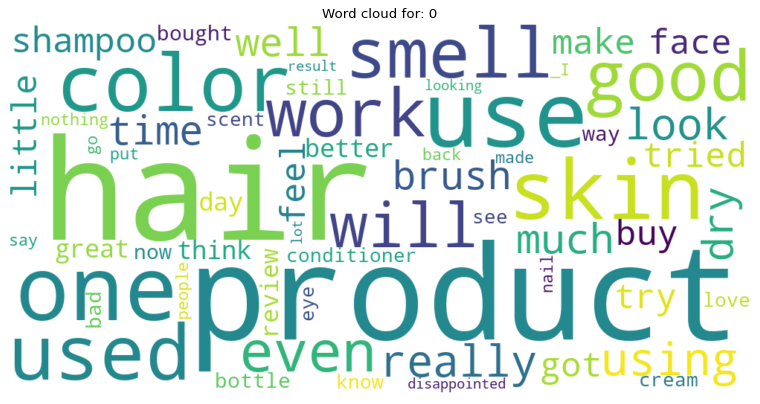

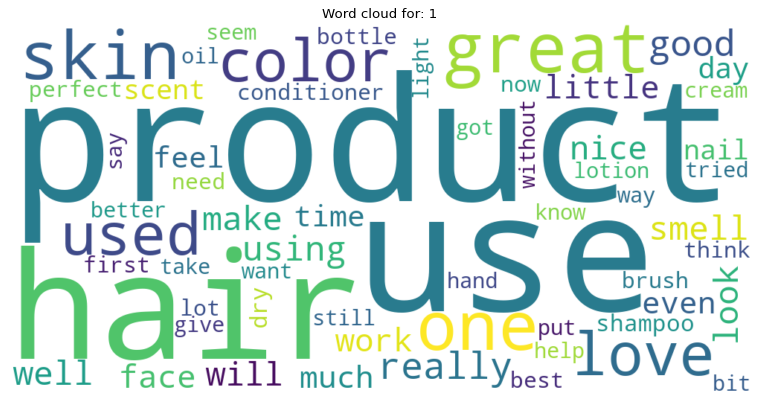

In [ ]:
parseWord(xy_train_df, 0)
parseWord(xy_train_df, 1)

This is just to get a intuition which kinds of word may appear in the positive and negative sentences. I could not get any detailed information from the word cloud.

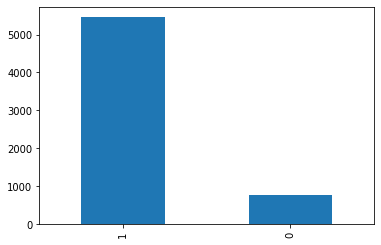

In [ ]:
xy_train_df["rating"].value_counts().plot.bar() # visualize the rating distribution

Notice that the positive sentence is dominant. The dataset is extremely unbalanced.

In [ ]:
negative, positive = np.bincount(xy_train_df["rating"]) # count the number of negative and positive sentences
print("negative sentences: {}, positive sentences: {}".format(negative, positive))

negative sentences: 771, positive sentences: 5452


In [ ]:
review_list = [] # review list for this whole dataset
for i in range(len(xy_train_df.review)):
    review_list += xy_train_df.review[i]  # add the reviews to one list so that I could see the special characters later

In [ ]:
special_char = ' '
for char in set(' '.join(review_list)):
    if re.findall('[^A-Za-z]', char): # use regex to find special characters
        special_char += char
sorted(special_char)

[' ',
 ' ',
 '!',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '=',
 '>',
 '?',
 '@',
 '[',
 ']',
 '^',
 '_',
 '`',
 '{',
 '}',
 '~']

The above is the special characters(other than english letters) that appear in the review.

In [ ]:
# text preprocessing and normalization:
# In this function, I replace the special characters with the space,
# change all letters to lower case, change the verb tense to default case
def clean(df):
    reviews = []
    for comment in df['review']:       
        #remove special characters
        review_text = re.sub("[^a-zA-Z]"," ", comment)
        #tokenize the sentences, change to lower case
        words = word_tokenize(review_text.lower())
        #lemmatize each word
        lemmatizer = WordNetLemmatizer()
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        reviews.append(lemma_words)
    return reviews


In [ ]:
train_clean_sentence = clean(xy_train_df) # pre-processing "review" in training dataset

In [ ]:
test_clean_sentence = clean(x_test_df) # for consistency, pre-processing "review" in test dataset

In [ ]:
print(len(train_clean_sentence)) # check for the function is correct or not by examing the length first. It is equal to the original dataset's length

6223


In [ ]:
# visualize the change between the original sentence and cleaned sentence
print(xy_train_df.iloc[0]["review"])
print(' '.join(train_clean_sentence[0]))

Five Stars_GOOD
five star good


In [ ]:
train_clean_sentence[:10] # visualize the cleaned version

[['five', 'star', 'good'],
 ['love', 'it', 'love', 'it'],
 ['five', 'star', 'good'],
 ['five', 'star', 'love'],
 ['love', 'these', 'so', 'cute'],
 ['five', 'star', 'love', 'it'],
 ['four', 'star', 'awesome'],
 ['five', 'star', 'dry', 'handy'],
 ['five', 'star', 'the', 'best'],
 ['five', 'star', 'cool', 'color']]

In [ ]:
def replace(df, new): # create a new dataset with cleaned "review" column
  df_temp = copy.deepcopy(df)
  df_temp["review"] = new
  return df_temp

In [ ]:
xy_train_new = replace(xy_train_df, train_clean_sentence)
xy_train_new.head() # visualize the cleaned train dataset

,id,rating,review,length
6037,2596,1,"[five, star, good]",15
5353,4643,1,"[love, it, love, it]",15
2545,8791,1,"[five, star, good]",15
3902,6098,1,"[five, star, love]",16
2850,4609,1,"[love, these, so, cute]",19


In [ ]:
x_test_new = replace(x_test_df, test_clean_sentence)
x_test_new # visualized the cleaned test dataset

,review,length
id,,
8950,"[five, star, love, them]",20
4945,"[five, star, nice, color]",21
9936,"[nice, nice, product, like, aaa]",26
4855,"[five, star, i, like, this, color]",29
6853,"[one, star, boo, cheap, don, t, buy]",31
...,...,...
8122,"[cover, gray, i, bought, this, dye, vidal, sas...",4714
6835,"[the, light, i, would, have, bought, this, lig...",4801
3950,"[clog, your, pore, stay, dirty, feel, stale, t...",4895


In [ ]:
print(len(list(xy_train_new[xy_train_new["id"] == 4823]["review"])[0])) # the longest review in training dataset has 2260 tokens

2260


In [ ]:
print(len(list(x_test_new.iloc[-1:]["review"])[0])) # the longest review in test dataset has 1170 tokens

1170


In [ ]:
# comment your understanding of each function and each parameter below:



vocab_size = 10000 # assume only deal with the top 10000 words
max_len = 500 # max length of padding sequence (max 500 words) original has 256 words

# xy_train, xy_validation = train_test_split(
#     xy_train_df, test_size=0.2)

# xy_train, xy_validation = train_test_split( # split the train dataset into train and validation
#     xy_train_new, test_size=0.2, random_state = 42)

xy_train, xy_validation = train_test_split( # split the train dataset into train and validation
    xy_train_df, test_size=0.2, random_state = 42)

# build vocabulary from training set
tokenizer = Tokenizer(num_words=vocab_size)
token_text = tokenizer.fit_on_texts(xy_train.review)


# padding each word vector into equal length vector
def _preprocess(texts):
  return pad_sequences(
      tokenizer.texts_to_sequences(texts),
      maxlen=max_len, 
      padding='post'
  )


x_train = _preprocess(xy_train.review) # padding training dataset
y_train = xy_train.rating

x_valid = _preprocess(xy_validation.review) # padding validation dataset
y_valid = xy_validation.rating

x_test = _preprocess(x_test_df.review) # padding test dataset
# x_test_new

print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

(4978, 500)
(1245, 500)
(2667, 500)


In [ ]:
#tokenizer.word_index
len(tokenizer.word_index) # unique token

14705

## RNN approach:

### Basic Functions:

In [ ]:
def plot_result(model_hist): # this function is to plot the accuracy/validation accuracy for the model
  plt.plot(model_hist.history['accuracy'], label='accuracy') # retrieve the accuracy
  plt.plot(model_hist.history['val_accuracy'], label = 'val_accuracy') # retrieve the validation accuracy
  plt.xlabel('Epoch') # show the plot with the above two values included
  plt.ylabel('Accuracy')
  plt.ylim([0.5, 1])
  plt.legend(loc='upper right')
  plt.show()

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping( # early stopping layer for prevent overfitting
    monitor='val_accuracy', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [ ]:
def get_cm(model, valid_x, valid_y): # get the confusion matrix for validation value and actual prediction
  y_pred = predict_class(model, x_valid)
  return confusion_matrix(y_valid, y_pred)

In [ ]:
def predict_class(model, _dataset): # predict the class 0 or 1
  classes = model.predict(_dataset) > 0.5
  return np.squeeze(classes * 1)

In [ ]:
def make_submission(test_id, pred_val, fileName): # make the submission file
  pd.DataFrame(
    {'id': test_id,
     'rating': pred_val}).to_csv(fileName, index=False)

In [ ]:
# unbalanced data, want to exam whether set the class weight will increase the model accuracy or not
class_0_weight = (1 / negative)*(negative + positive)/2.0 # scaling by total labels/2 suggested in the official document 
class_1_weight = (1 / positive)*(negative + positive)/2.0
class_weight_total = {0: class_0_weight, 1: class_1_weight} # concate class weight of 0 and 1
print('Weight for class 0: {}'.format(class_0_weight))
print('Weight for class 1: {}'.format(class_1_weight))

Weight for class 0: 4.035667963683528
Weight for class 1: 0.5707079970652972


### Baseline Model: Provided by Prof. Ding

In [ ]:
# comment your understanding of each line and 
# the output shape of each line below. for each dimensionality, explains its 
# meaning. (e.g. None is the batch size)

x = keras.Input((max_len)) # input is the length of each sentence, it is set to 256 in the previous sectioon

embeded = keras.layers.Embedding(vocab_size, 20)(x) # embedding dimension is 20, the shape is [256, 20]

averaged = tf.reduce_mean(embeded, axis=1) # dropout

pred = keras.layers.Dense(1, activation=tf.nn.sigmoid)(averaged) # dense layer, shape [1]

model = keras.Model(x, pred) # combining for a full model

model.compile( # complie model
    optimizer=Adam(clipnorm=4.), # clipnorm is used to prevent gradient explosion and vanish
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [ ]:
model.summary() # get the model summary

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 256, 20)           200000    
_________________________________________________________________
tf.math.reduce_mean_1 (TFOpL (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 200,021
Trainable params: 200,021
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=5,
                    batch_size=64,
                    validation_data=(x_valid, y_valid),
                    verbose=1) # train model, with validation data = validation set from train_test_split function

Epoch 1/5
78/78 [==============================] - 3s 7ms/step - loss: 0.6509 - accuracy: 0.8645 - val_loss: 0.5263 - val_accuracy: 0.8795
Epoch 2/5
78/78 [==============================] - 0s 5ms/step - loss: 0.4948 - accuracy: 0.8731 - val_loss: 0.4065 - val_accuracy: 0.8795
Epoch 3/5
78/78 [==============================] - 0s 5ms/step - loss: 0.3985 - accuracy: 0.8754 - val_loss: 0.3712 - val_accuracy: 0.8795
Epoch 4/5
78/78 [==============================] - 0s 5ms/step - loss: 0.3745 - accuracy: 0.8755 - val_loss: 0.3649 - val_accuracy: 0.8795
Epoch 5/5
78/78 [==============================] - 0s 5ms/step - loss: 0.3629 - accuracy: 0.8789 - val_loss: 0.3626 - val_accuracy: 0.8795


In [ ]:
model.evaluate(x_valid, y_valid) # evaluate the model performance in the validation dataset

39/39 [==============================] - 0s 2ms/step - loss: 0.3626 - accuracy: 0.8795


[0.36258718371391296, 0.8795180916786194]

### GRU Model:

#### One-Direction GRU:

In [ ]:
# One direction, one layer GRU model
model_GRU = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index)+1, 256, input_length = max_len), # embedding shape: [max length of sentence, 256] = [256, 256]
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.GRU(128), # GRU layer, 128 units
    tf.keras.layers.Dense(128, activation='relu'), # Dense layer, 128 units
    tf.keras.layers.Dropout(0.2), # dropout 20% of features
    tf.keras.layers.Dense(1, activation='sigmoid') # Dense layer, 1 unit
                        
])
model_GRU.compile(loss='binary_crossentropy', optimizer=Adam(clipnorm=4.), metrics=['accuracy']) # compile the model
model_GRU.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 256)          3051008   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 256, 256)          0         
_________________________________________________________________
gru (GRU)                    (None, 128)               148224    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,215,873
Trainable params: 3,215,873
Non-trainable params: 0
______________________________________________

In [ ]:
history_GRU = model_GRU.fit(x_train,
                    y_train,
                    epochs=15,
                    batch_size=64,
                    validation_data=(x_valid, y_valid),
                    verbose=1,
                    callbacks=[early_stopping]) # train model with early stopping

Epoch 1/15
78/78 [==============================] - 34s 41ms/step - loss: 0.4583 - accuracy: 0.8453 - val_loss: 0.3956 - val_accuracy: 0.8675
Epoch 2/15
78/78 [==============================] - 3s 37ms/step - loss: 0.3789 - accuracy: 0.8756 - val_loss: 0.3943 - val_accuracy: 0.8675
Epoch 3/15
78/78 [==============================] - 3s 36ms/step - loss: 0.3459 - accuracy: 0.8900 - val_loss: 0.3911 - val_accuracy: 0.8675
Epoch 4/15
78/78 [==============================] - 3s 36ms/step - loss: 0.3565 - accuracy: 0.8826 - val_loss: 0.3996 - val_accuracy: 0.8683
Epoch 5/15
78/78 [==============================] - 3s 36ms/step - loss: 0.3579 - accuracy: 0.8836 - val_loss: 0.3933 - val_accuracy: 0.8651
Epoch 6/15
78/78 [==============================] - 3s 36ms/step - loss: 0.3459 - accuracy: 0.8914 - val_loss: 0.3952 - val_accuracy: 0.8659
Epoch 7/15
78/78 [==============================] - 3s 36ms/step - loss: 0.3617 - accuracy: 0.8817 - val_loss: 0.4113 - val_accuracy: 0.8610
Restoring mo

In [ ]:
model_GRU.evaluate(x_valid, y_valid) # evaluate the model

39/39 [==============================] - 0s 7ms/step - loss: 0.3996 - accuracy: 0.8683


[0.3995600938796997, 0.8682730793952942]

In [ ]:
print(get_cm(model_GRU, x_valid, y_valid)) # I could see that most of the reviews are classified as positive, just 1 review is classified as negative

[[   1  164]
 [   0 1080]]


In [ ]:
make_submission(x_test_new.index, predict_class(model_GRU, x_test), "submission_oneDirGRU.csv") # ~0.87, basically same score as the base line

Observing that the performance between embed on 10000 vocabulary size and embed on the actual word size (len(tokenizer.word_index)) are the same. So at least thee two optionals is the same in the one directional GRU model

#### Bi-Directional GRU:

##### One layer Bi-Directional GRU:

In [ ]:
# try model with class weight, since the data is extremely unbalanced
model_biGRUone = tf.keras.Sequential([ # with class weight
    tf.keras.layers.Embedding(len(tokenizer.word_index)+1, 256, input_length = max_original), # output dim = 256
    tf.keras.layers.SpatialDropout1D(0.2), # dropout layer 
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128)), # one bidirectional GRU layer with 128 units
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2), # another dropout layer
    tf.keras.layers.Dense(1, activation='sigmoid')
                        
])
model_biGRUone.compile(loss='binary_crossentropy', optimizer=Adam(clipnorm=4.), metrics=['accuracy'])
model_biGRUone.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 256, 256)          3051008   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 256, 256)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               296448    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 3,380,481
Trainable params: 3,380,481
Non-trainable params: 0
____________________________________________

In [ ]:
history_biGRUone = model_biGRUone.fit(x_train,
                    y_train,
                    epochs=15,
                    batch_size=64,
                    validation_data=(x_valid, y_valid),
                    verbose=1,
                    callbacks=[early_stopping],
                    class_weight=class_weight_total)

Epoch 1/15
78/78 [==============================] - 7s 59ms/step - loss: 0.5952 - accuracy: 0.8069 - val_loss: 0.3241 - val_accuracy: 0.8522
Epoch 2/15
78/78 [==============================] - 4s 52ms/step - loss: 0.2387 - accuracy: 0.9163 - val_loss: 0.2571 - val_accuracy: 0.8932
Epoch 3/15
78/78 [==============================] - 4s 52ms/step - loss: 0.1312 - accuracy: 0.9553 - val_loss: 0.2455 - val_accuracy: 0.9149
Epoch 4/15
78/78 [==============================] - 4s 52ms/step - loss: 0.0691 - accuracy: 0.9799 - val_loss: 0.3231 - val_accuracy: 0.8859
Epoch 5/15
78/78 [==============================] - 4s 50ms/step - loss: 0.0385 - accuracy: 0.9865 - val_loss: 0.2997 - val_accuracy: 0.8892
Epoch 6/15
78/78 [==============================] - 4s 51ms/step - loss: 0.0548 - accuracy: 0.9781 - val_loss: 0.2997 - val_accuracy: 0.9205
Epoch 7/15
78/78 [==============================] - 4s 52ms/step - loss: 0.0148 - accuracy: 0.9966 - val_loss: 0.4025 - val_accuracy: 0.9052
Epoch 8/15
78

Notice that the validation loss in unstable, while the training accuracy is strictly increasing. It is the signal of overfitting

In [ ]:
model_biGRUone.evaluate(x_valid, y_valid) # the performance is not good

39/39 [==============================] - 0s 11ms/step - loss: 0.2997 - accuracy: 0.9205


[0.2997424304485321, 0.9204819202423096]

In [ ]:
print(get_cm(model_biGRUone, x_valid, y_valid))

[[ 107   58]
 [  41 1039]]


In [ ]:
make_submission(x_test_new.index, predict_class(model_biGRUone, x_test), "submission_biDirGRUcw1.csv")

##### Two-layer Bi-Derectional GRU:

In [ ]:
model_biGRU = tf.keras.Sequential([ # with vocab_size = 10000, no class weight
    tf.keras.layers.Embedding(vocab_size, 256, input_length = max_len),
    tf.keras.layers.SpatialDropout1D(0.5), # dropout layer
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, dropout = 0.5, recurrent_dropout = 0.5, return_sequences=True)),# in order to prevent overfitting, I add dropout parameter in the GRU layer
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, dropout = 0.5, recurrent_dropout = 0.5)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2), # dropout layer
    tf.keras.layers.Dense(1, activation='sigmoid')
                        
])

model_biGRU.compile(loss='binary_crossentropy', optimizer=Adam(clipnorm=4.), metrics=['accuracy'])
model_biGRU.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 256, 256)          2560000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 256, 256)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256, 256)          296448    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               123648    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [ ]:
history_biGRU = model_biGRU.fit(x_train,
                    y_train,
                    epochs=15,
                    batch_size=64,
                    validation_data=(x_valid, y_valid),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/15
78/78 [==============================] - 186s 2s/step - loss: 0.4334 - accuracy: 0.8639 - val_loss: 0.2313 - val_accuracy: 0.9060
Epoch 2/15
78/78 [==============================] - 178s 2s/step - loss: 0.2070 - accuracy: 0.9149 - val_loss: 0.1947 - val_accuracy: 0.9301
Epoch 3/15
78/78 [==============================] - 178s 2s/step - loss: 0.1353 - accuracy: 0.9491 - val_loss: 0.1890 - val_accuracy: 0.9285
Epoch 4/15
78/78 [==============================] - 180s 2s/step - loss: 0.1060 - accuracy: 0.9652 - val_loss: 0.1933 - val_accuracy: 0.9253
Epoch 5/15
78/78 [==============================] - 178s 2s/step - loss: 0.0727 - accuracy: 0.9756 - val_loss: 0.1935 - val_accuracy: 0.9293
Epoch 6/15
78/78 [==============================] - 179s 2s/step - loss: 0.0513 - accuracy: 0.9805 - val_loss: 0.2344 - val_accuracy: 0.9341
Epoch 7/15
78/78 [==============================] - 178s 2s/step - loss: 0.0356 - accuracy: 0.9884 - val_loss: 0.1992 - val_accuracy: 0.9277
Epoch 8/15
78

The performance is better than the previous models, the validation loss is not changing too muchm and the accuracy is increasing strictly

In [ ]:
model_biGRU.evaluate(x_valid, y_valid)

39/39 [==============================] - 6s 164ms/step - loss: 0.2344 - accuracy: 0.9341


[0.2343965470790863, 0.9341365694999695]

In [ ]:
y_predGRU = predict_class(model_biGRU, x_valid)
print(confusion_matrix(y_valid, y_predGRU))

[[  72   69]
 [  13 1091]]


In [ ]:
print(f1_score(y_valid, y_predGRU, average='micro'))

0.934136546184739


In [ ]:
make_submission(x_test_new.index, predict_class(model_biGRU, x_test), "submission_GRU1.csv")

Examining the effect of adding class weights in bi-directional GRU

In [ ]:
model_biGRUtwo = tf.keras.Sequential([ # with class weight
    tf.keras.layers.Embedding(len(tokenizer.word_index)+1, 256, input_length = max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, dropout = 0.5, recurrent_dropout = 0.5, return_sequences=True)),
    tf.keras.layers.SpatialDropout1D(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, dropout = 0.5, recurrent_dropout = 0.5)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
                        
])

model_biGRUtwo.compile(loss='binary_crossentropy', optimizer=Adam(clipnorm=4.), metrics=['accuracy'])
model_biGRUtwo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 256)          3764736   
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 256)          296448    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 500, 256)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               296448    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [ ]:
history_biGRUtwo = model_biGRUtwo.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(x_valid, y_valid),
                    verbose=1,
                    callbacks=[early_stopping],
                    class_weight = class_weight_total)

Epoch 1/20
39/39 [==============================] - 619s 16s/step - loss: 0.6761 - accuracy: 0.5664 - val_loss: 0.4725 - val_accuracy: 0.7855
Epoch 2/20
39/39 [==============================] - 593s 15s/step - loss: 0.3222 - accuracy: 0.8454 - val_loss: 0.3198 - val_accuracy: 0.8618
Epoch 3/20
39/39 [==============================] - 593s 15s/step - loss: 0.1442 - accuracy: 0.9423 - val_loss: 0.2716 - val_accuracy: 0.9020
Epoch 4/20
39/39 [==============================] - 591s 15s/step - loss: 0.0925 - accuracy: 0.9720 - val_loss: 0.4413 - val_accuracy: 0.8707
Epoch 5/20
39/39 [==============================] - 591s 15s/step - loss: 0.0712 - accuracy: 0.9688 - val_loss: 0.3214 - val_accuracy: 0.9068
Epoch 6/20
39/39 [==============================] - 590s 15s/step - loss: 0.0354 - accuracy: 0.9873 - val_loss: 0.3260 - val_accuracy: 0.9052
Epoch 7/20
39/39 [==============================] - 589s 15s/step - loss: 0.0183 - accuracy: 0.9953 - val_loss: 0.5052 - val_accuracy: 0.8843
Epoch 

In [ ]:
model_biGRUtwo.evaluate(x_valid, y_valid)

39/39 [==============================] - 22s 550ms/step - loss: 0.3214 - accuracy: 0.9068


[0.3213655948638916, 0.9068273305892944]

In [ ]:
print(get_cm(model_biGRUtwo, x_valid, y_valid))

[[  98   48]
 [  68 1031]]


### LSTM Model:

##### One-Direction LSTM:

In [ ]:
model_oneLSTM = tf.keras.Sequential([ # one directional LSTM
    tf.keras.layers.Embedding(len(tokenizer.word_index)+1, 200, input_length = max_len), # input dim: total token of words, output dim: 200, each has length max_len
    tf.keras.layers.LSTM(128, dropout = 0.5, recurrent_dropout=0.5, return_sequences=False),
    tf.keras.layers.Dense(128, activation = 'relu'), # Dense layer, has 128 units 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_oneLSTM.compile(
    optimizer=Adam(clipnorm=4.),
    loss='binary_crossentropy',
    metrics=['accuracy'])
model_oneLSTM.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 256, 200)          2383600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 2,568,689
Trainable params: 2,568,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_oneLSTM = model_oneLSTM.fit(x_train,
                    y_train,
                    epochs=15,
                    batch_size=64,
                    validation_data=(x_valid, y_valid),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/15
78/78 [==============================] - 57s 707ms/step - loss: 0.4439 - accuracy: 0.8624 - val_loss: 0.3943 - val_accuracy: 0.8675
Epoch 2/15
78/78 [==============================] - 55s 712ms/step - loss: 0.3662 - accuracy: 0.8843 - val_loss: 0.3974 - val_accuracy: 0.8675
Epoch 3/15
78/78 [==============================] - 55s 702ms/step - loss: 0.3913 - accuracy: 0.8713 - val_loss: 0.3974 - val_accuracy: 0.8675
Epoch 4/15
78/78 [==============================] - 54s 696ms/step - loss: 0.3610 - accuracy: 0.8835 - val_loss: 0.3899 - val_accuracy: 0.8683
Epoch 5/15
78/78 [==============================] - 54s 689ms/step - loss: 0.3600 - accuracy: 0.8848 - val_loss: 0.3971 - val_accuracy: 0.8675
Epoch 6/15
78/78 [==============================] - 54s 693ms/step - loss: 0.3800 - accuracy: 0.8776 - val_loss: 0.4005 - val_accuracy: 0.8643
Epoch 7/15
78/78 [==============================] - 54s 687ms/step - loss: 0.3610 - accuracy: 0.8850 - val_loss: 0.3983 - val_accuracy: 0.8643

In [ ]:
model_oneLSTM.evaluate(x_valid, y_valid)

39/39 [==============================] - 2s 50ms/step - loss: 0.3899 - accuracy: 0.8683


[0.38985881209373474, 0.8682730793952942]

In [ ]:
print(get_cm(model_oneLSTM, x_valid, y_valid)) # very bad performance, does not catch the pattern for negative sentence

[[   1  164]
 [   0 1080]]


##### Bi-Directiona; LSTM:

###### One layer Bi-Directional LSTM:

In [ ]:
model_LSTM = tf.keras.Sequential([ # bi-directional LSTM
    tf.keras.layers.Embedding(len(tokenizer.word_index)+1, 200, input_length = max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout = 0.5, recurrent_dropout=0.5, return_sequences=False)), # 
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_LSTM.compile(
    optimizer=Adam(clipnorm=4.),
    loss='binary_crossentropy',
    metrics=['accuracy'])
model_LSTM.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 256, 200)          2383600   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 2,753,521
Trainable params: 2,753,521
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_LSTM = model_LSTM.fit(x_train,
                    y_train,
                    epochs=15,
                    batch_size=64,
                    validation_data=(x_valid, y_valid),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/15
78/78 [==============================] - 111s 1s/step - loss: 0.4425 - accuracy: 0.8594 - val_loss: 0.2431 - val_accuracy: 0.9044
Epoch 2/15
78/78 [==============================] - 105s 1s/step - loss: 0.1850 - accuracy: 0.9247 - val_loss: 0.2174 - val_accuracy: 0.9237
Epoch 3/15
78/78 [==============================] - 105s 1s/step - loss: 0.0849 - accuracy: 0.9708 - val_loss: 0.2478 - val_accuracy: 0.9213
Epoch 4/15
78/78 [==============================] - 105s 1s/step - loss: 0.0596 - accuracy: 0.9783 - val_loss: 0.2616 - val_accuracy: 0.9221
Epoch 5/15
78/78 [==============================] - 104s 1s/step - loss: 0.0277 - accuracy: 0.9930 - val_loss: 0.3380 - val_accuracy: 0.9165
Restoring model weights from the end of the best epoch.
Epoch 00005: early stopping


In [ ]:
model_LSTM.evaluate(x_valid, y_valid)

39/39 [==============================] - 4s 92ms/step - loss: 0.2174 - accuracy: 0.9237


[0.2174045294523239, 0.9236947894096375]

In [ ]:
print(get_cm(model_LSTM, x_valid, y_valid))

[[  84   81]
 [  14 1066]]


In [ ]:
make_submission(x_test_new.index, predict_class(model_LSTM, x_test), "submission_oneLSTMcw.csv")

###### Two-layer Bi-Directional LSTM:

In [ ]:
model_biLSTM = tf.keras.Sequential([ 
    tf.keras.layers.Embedding(vocab_size, 200, input_length = max_len), # input length is 10000 instead of length of tokens
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout = 0.8, recurrent_dropout=0.8, return_sequences=True)), # add dropout parameter to prevent overfitting in both direction
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout = 0.5, recurrent_dropout=0.5, return_sequences=False)), # 
    tf.keras.layers.Dense(128, activation = 'relu'), # Dense layer, 128 units
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_biLSTM.compile(
    optimizer=Adam(clipnorm=4.),
    loss='binary_crossentropy',
    metrics=['accuracy'])

model_biLSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 256, 200)          2000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256, 256)          336896    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 2,517,889
Trainable params: 2,517,889
Non-trainable params: 0
______________________________________________

In [ ]:
history_biLSTM = model_biLSTM.fit(x_train,
                    y_train,
                    epochs=5,
                    batch_size=64,
                    validation_data=(x_valid, y_valid),
                    verbose=1)

Epoch 1/5
78/78 [==============================] - 204s 3s/step - loss: 0.4532 - accuracy: 0.8423 - val_loss: 0.2256 - val_accuracy: 0.9052
Epoch 2/5
78/78 [==============================] - 196s 3s/step - loss: 0.2163 - accuracy: 0.9077 - val_loss: 0.1925 - val_accuracy: 0.9237
Epoch 3/5
78/78 [==============================] - 196s 3s/step - loss: 0.1341 - accuracy: 0.9479 - val_loss: 0.1884 - val_accuracy: 0.9261
Epoch 4/5
78/78 [==============================] - 196s 3s/step - loss: 0.1098 - accuracy: 0.9619 - val_loss: 0.1977 - val_accuracy: 0.9406
Epoch 5/5
78/78 [==============================] - 196s 3s/step - loss: 0.0702 - accuracy: 0.9767 - val_loss: 0.1964 - val_accuracy: 0.9301


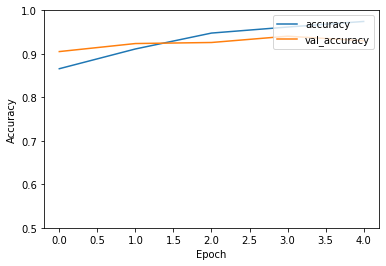

In [ ]:
plot_result(history_biLSTM) # seems a good model, plot the result

In [ ]:
model_biLSTM.evaluate(x_valid, y_valid) # evaluate on the validation dataset

39/39 [==============================] - 7s 169ms/step - loss: 0.1964 - accuracy: 0.9301


[0.19640807807445526, 0.9301204681396484]

In [ ]:
y_predLSTM = predict_class(model_biLSTM, x_valid)
print(confusion_matrix(y_valid, y_predLSTM))

[[  89   52]
 [  35 1069]]


In [ ]:
print(f1_score(y_valid, y_predLSTM, average='micro'))

0.9301204819277109


In [ ]:
make_submission(x_test_new.index, predict_class(model_biLSTM, x_test), "submission_LSTM1.csv")

Now change input dim to the length of tokens, comparing the performance:

In [ ]:
model_biLSTM2 = tf.keras.Sequential([ # input dim = tokenizer + 1, output dim = 300, maxlen = 500
    tf.keras.layers.Embedding(len(tokenizer.word_index)+1, 300, input_length = max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout = 0.8, recurrent_dropout=0.8, return_sequences=True)), # same as previous one
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout = 0.5, recurrent_dropout=0.5, return_sequences=False)), # 
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_biLSTM2.compile(
    optimizer=Adam(clipnorm=4.),
    loss='binary_crossentropy',
    metrics=['accuracy'])

model_biLSTM2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          4411800   
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 256)          439296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 5,032,089
Trainable params: 5,032,089
Non-trainable params: 0
______________________________________________

In [ ]:
history_biLSTM2 = model_biLSTM2.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(x_valid, y_valid),
                    verbose=1)

Epoch 1/10
78/78 [==============================] - 414s 5s/step - loss: 0.4374 - accuracy: 0.8627 - val_loss: 0.2302 - val_accuracy: 0.9036
Epoch 2/10
78/78 [==============================] - 401s 5s/step - loss: 0.1914 - accuracy: 0.9249 - val_loss: 0.1970 - val_accuracy: 0.9237
Epoch 3/10
78/78 [==============================] - 400s 5s/step - loss: 0.1293 - accuracy: 0.9538 - val_loss: 0.2107 - val_accuracy: 0.9221
Epoch 4/10
78/78 [==============================] - 395s 5s/step - loss: 0.0791 - accuracy: 0.9745 - val_loss: 0.2011 - val_accuracy: 0.9237
Epoch 5/10
78/78 [==============================] - 392s 5s/step - loss: 0.0580 - accuracy: 0.9777 - val_loss: 0.2346 - val_accuracy: 0.9149
Epoch 6/10
78/78 [==============================] - 393s 5s/step - loss: 0.0407 - accuracy: 0.9833 - val_loss: 0.3304 - val_accuracy: 0.9197
Epoch 7/10
78/78 [==============================] - 394s 5s/step - loss: 0.0340 - accuracy: 0.9888 - val_loss: 0.4281 - val_accuracy: 0.9157
Epoch 8/10
78

The performance does not has conspicuous different two models.

In [ ]:
model_biLSTM2.evaluate(x_valid, y_valid)

39/39 [==============================] - 13s 330ms/step - loss: 0.4389 - accuracy: 0.9213


[0.4388575255870819, 0.9212851524353027]

In [ ]:
print(get_cm(model_biLSTM2, x_valid, y_valid))

[[  77   69]
 [  29 1070]]


In [ ]:
make_submission(x_test_new.index, predict_class(model_biLSTM2, x_test), "submission_LSTM_2.csv")

###### 3rd

In [ ]:
model_biLSTM3 = tf.keras.Sequential([ # input dim = 10000, output dim = 300, maxlen = 500
    tf.keras.layers.Embedding(vocab_size, 300, input_length = max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout = 0.8, recurrent_dropout=0.8, return_sequences=True)), # 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout = 0.5, recurrent_dropout=0.5, return_sequences=False)), # 
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_biLSTM3.compile(
    optimizer=Adam(clipnorm=4.),
    loss='binary_crossentropy',
    metrics=['accuracy'])

model_biLSTM3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          3000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 500, 256)          439296    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 3,866,561
Trainable params: 3,866,561
Non-trainable params: 0
____________________________________________

In [ ]:
history_biLSTM3 = model_biLSTM3.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(x_valid, y_valid),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/10
78/78 [==============================] - 846s 11s/step - loss: 0.4357 - accuracy: 0.8421 - val_loss: 0.2369 - val_accuracy: 0.8972
Epoch 2/10
78/78 [==============================] - 830s 11s/step - loss: 0.1999 - accuracy: 0.9187 - val_loss: 0.2156 - val_accuracy: 0.9076
Epoch 3/10
78/78 [==============================] - 831s 11s/step - loss: 0.1389 - accuracy: 0.9551 - val_loss: 0.2340 - val_accuracy: 0.9229
Epoch 4/10
78/78 [==============================] - 833s 11s/step - loss: 0.0766 - accuracy: 0.9722 - val_loss: 0.2372 - val_accuracy: 0.9277
Epoch 5/10
78/78 [==============================] - 826s 11s/step - loss: 0.0613 - accuracy: 0.9802 - val_loss: 0.2567 - val_accuracy: 0.9301
Epoch 6/10
78/78 [==============================] - 833s 11s/step - loss: 0.0387 - accuracy: 0.9861 - val_loss: 0.2762 - val_accuracy: 0.9237
Epoch 7/10
78/78 [==============================] - 826s 11s/step - loss: 0.0285 - accuracy: 0.9888 - val_loss: 0.2868 - val_accuracy: 0.9357
Epoch 

In [ ]:
model_biLSTM3.evaluate(x_valid, y_valid)

39/39 [==============================] - 31s 796ms/step - loss: 0.2868 - accuracy: 0.9357


[0.28678447008132935, 0.935742974281311]

In [ ]:
print(get_cm(model_biLSTM3, x_valid, y_valid))

[[  98   48]
 [  32 1067]]


In [ ]:
make_submission(x_test_df.index, predict_class(model_biLSTM3, x_test), "submission_LSTM_3.csv")

###### 4th

In [ ]:
model_biLSTM4 = tf.keras.Sequential([ # input dim = tokenizer + 1, output dim = 300, maxlen = 500, original dataset
    tf.keras.layers.Embedding(len(tokenizer.word_index)+1, 300, input_length = max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout = 0.8, recurrent_dropout=0.8, return_sequences=True)), # 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout = 0.5, recurrent_dropout=0.5, return_sequences=False)), # 
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_biLSTM4.compile(
    optimizer=Adam(clipnorm=4.),
    loss='binary_crossentropy',
    metrics=['accuracy'])

model_biLSTM4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 300)          4411800   
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 256)          439296    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 5,278,361
Trainable params: 5,278,361
Non-trainable params: 0
______________________________________________

In [ ]:
history_biLSTM4 = model_biLSTM4.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(x_valid, y_valid),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/10
78/78 [==============================] - 401s 5s/step - loss: 0.4306 - accuracy: 0.8654 - val_loss: 0.2359 - val_accuracy: 0.8996
Epoch 2/10
78/78 [==============================] - 392s 5s/step - loss: 0.1917 - accuracy: 0.9252 - val_loss: 0.1943 - val_accuracy: 0.9237
Epoch 3/10
78/78 [==============================] - 391s 5s/step - loss: 0.1211 - accuracy: 0.9535 - val_loss: 0.2974 - val_accuracy: 0.9124
Epoch 4/10
78/78 [==============================] - 393s 5s/step - loss: 0.0756 - accuracy: 0.9708 - val_loss: 0.2137 - val_accuracy: 0.9301
Epoch 5/10
78/78 [==============================] - 391s 5s/step - loss: 0.0389 - accuracy: 0.9878 - val_loss: 0.2347 - val_accuracy: 0.9349
Epoch 6/10
78/78 [==============================] - 391s 5s/step - loss: 0.0363 - accuracy: 0.9876 - val_loss: 0.3045 - val_accuracy: 0.9301
Epoch 7/10
78/78 [==============================] - 395s 5s/step - loss: 0.0235 - accuracy: 0.9915 - val_loss: 0.2815 - val_accuracy: 0.9205
Epoch 8/10
78

In [ ]:
model_biLSTM4.evaluate(x_valid, y_valid)

39/39 [==============================] - 13s 334ms/step - loss: 0.2347 - accuracy: 0.9349


[0.23469948768615723, 0.9349397420883179]

In [ ]:
print(get_cm(model_biLSTM4, x_valid, y_valid))

[[  92   54]
 [  27 1072]]


In [ ]:
make_submission(x_test_df.index, predict_class(model_biLSTM4, x_test), "submission_LSTM_6.csv")

### LSTM + Word2Vec Embedding:

In [ ]:
import gensim.downloader as api

w2v = api.load('word2vec-google-news-300')


[=================================================-] 99.5% 1655.0/1662.8MB downloaded


In [ ]:
early_stopping_lstm = tf.keras.callbacks.EarlyStopping( # early stopping layer for prevent overfitting
    monitor='val_loss', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [ ]:
# mapping the tokens appear in the "review" column with the word2vec matrix
num_words = len(tokenizer.word_index)+1
embedding_matrix = np.zeros((num_words, 300)) # google news word2vec model has dimension of 300
for word, i in tokenizer.word_index.items():
    if word in w2v.vocab:
        embedding_matrix[i] = w2v.word_vec(word)

In [ ]:
# use the pre-trained word2vec model as the embidding layer
embedding_layer = tf.keras.layers.Embedding(num_words,
        300,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False) # this layer is not trainable

In [ ]:
model_LSTMw2v = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout = 0.8, recurrent_dropout=0.8, return_sequences=True)), # same as the previous LSTM model
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout = 0.5, recurrent_dropout=0.5, return_sequences=False)), # 
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_LSTMw2v.compile(
    optimizer=Adam(clipnorm=4.),
    loss='binary_crossentropy',
    metrics=['accuracy'])

model_LSTMw2v.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          4411800   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 500, 256)          439296    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 5,278,361
Trainable params: 866,561
Non-trainable params: 4,411,800
______________________________________

In [ ]:
history_LSTMw2v = model_LSTMw2v.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(x_valid, y_valid),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/20
39/39 [==============================] - 206s 5s/step - loss: 0.4709 - accuracy: 0.8143 - val_loss: 0.3014 - val_accuracy: 0.8827
Epoch 2/20
39/39 [==============================] - 198s 5s/step - loss: 0.3027 - accuracy: 0.8778 - val_loss: 0.2510 - val_accuracy: 0.8843
Epoch 3/20
39/39 [==============================] - 197s 5s/step - loss: 0.2756 - accuracy: 0.8851 - val_loss: 0.2111 - val_accuracy: 0.9133
Epoch 4/20
39/39 [==============================] - 197s 5s/step - loss: 0.2498 - accuracy: 0.8991 - val_loss: 0.2310 - val_accuracy: 0.9036
Epoch 5/20
39/39 [==============================] - 197s 5s/step - loss: 0.2438 - accuracy: 0.8959 - val_loss: 0.2126 - val_accuracy: 0.9149
Epoch 6/20
39/39 [==============================] - 196s 5s/step - loss: 0.2270 - accuracy: 0.9087 - val_loss: 0.2059 - val_accuracy: 0.9116
Epoch 7/20
39/39 [==============================] - 198s 5s/step - loss: 0.2308 - accuracy: 0.9038 - val_loss: 0.1843 - val_accuracy: 0.9269
Epoch 8/20
39

In [ ]:
model_LSTMw2v.evaluate(x_valid, y_valid) # evaluate model

39/39 [==============================] - 13s 345ms/step - loss: 0.1843 - accuracy: 0.9269


[0.18431265652179718, 0.9269076585769653]

In [ ]:
print(get_cm(model_LSTMw2v, x_valid, y_valid))

[[  87   59]
 [  32 1067]]


In [ ]:
make_submission(x_test_df.index, predict_class(model_LSTMw2v, x_test), "submission_LSTM_7.csv")

In [ ]:
model_LSTMw2v2 = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout = 0.8, recurrent_dropout=0.8, return_sequences=True)), # 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)), # different unit
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_LSTMw2v2.compile(
    optimizer=Adam(clipnorm=4.),
    loss='binary_crossentropy',
    metrics=['accuracy'])

model_LSTMw2v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          4411800   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 500, 256)          439296    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 5,032,089
Trainable params: 620,289
Non-trainable params: 4,411,800
______________________________________

In [ ]:
history_LSTMw2v2 = model_LSTMw2v2.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(x_valid, y_valid),
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/20
39/39 [==============================] - 369s 9s/step - loss: 0.4797 - accuracy: 0.8243 - val_loss: 0.3301 - val_accuracy: 0.8827
Epoch 2/20
39/39 [==============================] - 359s 9s/step - loss: 0.3244 - accuracy: 0.8778 - val_loss: 0.2294 - val_accuracy: 0.8940
Epoch 3/20
39/39 [==============================] - 357s 9s/step - loss: 0.2672 - accuracy: 0.8897 - val_loss: 0.2527 - val_accuracy: 0.8908
Epoch 4/20
39/39 [==============================] - 358s 9s/step - loss: 0.2498 - accuracy: 0.8945 - val_loss: 0.1921 - val_accuracy: 0.9197
Epoch 5/20
39/39 [==============================] - 359s 9s/step - loss: 0.2518 - accuracy: 0.8969 - val_loss: 0.1924 - val_accuracy: 0.9213
Epoch 6/20
39/39 [==============================] - 360s 9s/step - loss: 0.2407 - accuracy: 0.9108 - val_loss: 0.2064 - val_accuracy: 0.9197
Epoch 7/20
39/39 [==============================] - 358s 9s/step - loss: 0.2493 - accuracy: 0.8981 - val_loss: 0.2519 - val_accuracy: 0.9020
Epoch 8/20
39

In [ ]:
model_LSTMw2v2.evaluate(x_valid, y_valid)

39/39 [==============================] - 21s 547ms/step - loss: 0.1924 - accuracy: 0.9213


[0.1924322545528412, 0.9212851524353027]

In [ ]:
print(get_cm(model_LSTMw2v2, x_valid, y_valid))

[[  86   60]
 [  38 1061]]


## Questions:

1.

The many-to-many problem is mapping a sequence of words to another sequence of words. Typically the translation task falls into this kind of problems.

The many to one problem is mapping a squence of words to a single class. Typically binary classification of sequence of words (sentiment analysis) falls into the kind of problem.

2.

Gradient Vanishing: in multi-layer neural network, the parameters are updated based on the gradient descent where we have to computes the partial derivative. However, for some layers, the calculation of gradient will based on chain rule. Therefore, if one of the elements in chain rule is < 1, then the overall will decrease exponentially and finally reach 0, leads gradient Vanishing.

Graident Explosion: the same as above except the element in chain rule is now > 1, the overall will increase exponentially and finlly goes to infinity, leads to gradient explosion.

3.

In the sample model, there are no such function to handle with the time dimension. The reduce_mean() function is used for reduce dimensionality of the embedding layer, not exactly used for handling time dimension. I would not suggest to use this method because it could not catch the information between contexts.

4.

The main differences between GRU and LSTM are GRU has two gates, namely update gate and reset gate; while LSTM has three gates, namely input gate, output gate and forget gate. LSTM in theory could memorize longer sequence than GRU but GRU is simpler than LSTM and easy to modify.